In [6]:
import tensorflow as tf

# Check for TensorFlow GPU access
print(f"TensorFlow has access to the following devices:\n{tf.config.list_physical_devices()}")

# See TensorFlow version
print(f"TensorFlow version: {tf.__version__}")

TensorFlow has access to the following devices:
[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'), PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
TensorFlow version: 2.13.0


In [7]:
import sklearn
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.layers import GRU, Dense, Dropout
import time
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# Load data
file_path = '2017_2024_data.xlsx'
sheet_name = 'Sheet1'
df = pd.read_excel(file_path, sheet_name=sheet_name)

df.set_index('Date', inplace=True)
df['Year'] = df.index.year
df['Month'] = df.index.month
df['Day'] = df.index.day

# Ensure 'EnergyDemand' is last column
cols = list(df.columns)
cols.append(cols.pop(cols.index('EnergyDemand')))
df = df[cols]

print(df.shape)
print(df.head())

# Split data into train, validation, and test sets
train_data = df.loc[:'2020-04-30']
val_data = df.loc['2020-05-01':'2022-04-30']
test_data = df.loc['2022-05-01':]

# Scale data
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_train_data = scaler.fit_transform(train_data)
scaled_val_data = scaler.fit_transform(val_data)
scaled_test_data = scaler.transform(test_data)

# Function to create a dataset for GRU
def create_dataset(data, look_back=1):
    x, y = [], []
    for i in range(len(data) - look_back):
        x.append(data[i:(i + look_back), :])
        y.append(data[i + look_back, -1])  # 'EnergyDemand'
    return np.array(x), np.array(y)

look_back = 365  # Number of previous days to use for predicting the next day
x_train, y_train = create_dataset(scaled_train_data, look_back)
x_val, y_val = create_dataset(scaled_val_data, look_back)
x_test, y_test = create_dataset(scaled_test_data, look_back)

print(f'x_train shape: {x_train.shape}, y_train shape: {y_train.shape}')
print(f'x_test shape: {x_test.shape}, y_test shape: {y_test.shape}')

model = Sequential()
model.add(GRU(100, return_sequences=True, input_shape=(look_back, x_train.shape[2]))) 
model.add(Dropout(0.4))
model.add(GRU(100, return_sequences=True))
model.add(Dropout(0.4))
model.add(GRU(100))
model.add(Dropout(0.4))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mean_squared_error', metrics=['mae'])
model.summary()

# Train the model
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

start_time = time.time()
history = model.fit(x_train, y_train, epochs=100, validation_data=(x_val, y_val), batch_size=32, verbose=1, callbacks=[early_stopping])
training_time = time.time() - start_time
print(f"Training time: {training_time:.2f} seconds")

# Prediction
start_time = time.time()
predicted_energy_usage = model.predict(x_test)
train_predictions = model.predict(x_train)
prediction_time = time.time() - start_time
print(f"Prediction time: {prediction_time:.2f} seconds")

# Inverse transform predicted values
# cross out for scaled error
predicted_energy_usage = scaler.inverse_transform(np.hstack((np.zeros((predicted_energy_usage.shape[0], scaled_test_data.shape[1] - 1)), predicted_energy_usage.reshape(-1, 1))))[:, -1]
train_predictions = scaler.inverse_transform(np.hstack((np.zeros((train_predictions.shape[0], scaled_train_data.shape[1] - 1)), train_predictions.reshape(-1, 1))))[:, -1]

# Prepare test data for plotting
test_data = pd.DataFrame(scaled_test_data, columns=df.columns, index=test_data.index)
test_data['PredictedEnergyDemand'] = np.nan

# Scaled error
# test_data.iloc[look_back:, test_data.columns.get_loc('PredictedEnergyDemand')] = scaler.inverse_transform(np.hstack((np.zeros((predicted_energy_usage.shape[0], scaled_test_data.shape[1] - 1)), predicted_energy_usage.reshape(-1, 1))))[:, -1]
# Unscaled error
test_data.iloc[look_back:, test_data.columns.get_loc('PredictedEnergyDemand')] = predicted_energy_usage

# Inverse transform the y_test and y_train values to their original scale
y_test_unscaled = scaler.inverse_transform(np.hstack((np.zeros((y_test.shape[0], scaled_test_data.shape[1] - 1)), y_test.reshape(-1, 1))))[:, -1]
y_train_unscaled = scaler.inverse_transform(np.hstack((np.zeros((y_train.shape[0], scaled_train_data.shape[1] - 1)), y_train.reshape(-1, 1))))[:, -1]


(2677, 18)
            StnPresMax  StnPresMin  TMax  TMin      RHMin   WS    WD  WSGust  \
Date                                                                           
2017-01-01      1010.8      1006.0  22.3  18.5  76.583513  4.3  25.0    14.2   
2017-01-02      1007.8      1004.2  25.5  21.4  76.583513  3.0  52.0     9.1   
2017-01-03      1007.7      1004.1  25.3  21.5  76.583513  3.8  49.0    10.2   
2017-01-04      1006.9      1003.2  23.9  21.0  76.583513  3.0  25.0    10.0   
2017-01-05      1004.6      1001.2  25.7  20.8  76.583513  1.2  18.0     6.2   

            WDGust  Precp  GloblRad  Population  TouristA  TouristD  Year  \
Date                                                                        
2017-01-01    18.0    6.0      1.35        3720       252       247  2017   
2017-01-02    67.0    0.5      5.10        3720       251       320  2017   
2017-01-03    17.0    1.0      6.85        3720       260       340  2017   
2017-01-04    25.0    1.0      8.40        

2024-08-15 21:25:29.919487: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-08-15 21:25:30.181042: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-08-15 21:25:30.239911: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-08-15 21:25:30.338921: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-08-15 21:25:30.465454: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-08-15 21:25:30.566078: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-08-15 21:25:30.662711: I tensorflow/core/grappler/optimizers/cust

27/27 [==============================] - ETA: 0s - loss: 0.0492 - mae: 0.1682

2024-08-15 21:25:32.833271: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-08-15 21:25:32.916912: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-08-15 21:25:32.957882: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-08-15 21:25:33.009497: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


27/27 [==============================] - 5s 104ms/step - loss: 0.0492 - mae: 0.1682 - val_loss: 0.0248 - val_mae: 0.1291
Epoch 2/100
27/27 [==============================] - 2s 75ms/step - loss: 0.0219 - mae: 0.1152 - val_loss: 0.0207 - val_mae: 0.1178
Epoch 3/100
27/27 [==============================] - 2s 76ms/step - loss: 0.0182 - mae: 0.1032 - val_loss: 0.0171 - val_mae: 0.1058
Epoch 4/100
27/27 [==============================] - 2s 76ms/step - loss: 0.0170 - mae: 0.0992 - val_loss: 0.0133 - val_mae: 0.0900
Epoch 5/100
27/27 [==============================] - 2s 75ms/step - loss: 0.0175 - mae: 0.1002 - val_loss: 0.0139 - val_mae: 0.0928
Epoch 6/100
27/27 [==============================] - 2s 75ms/step - loss: 0.0155 - mae: 0.0924 - val_loss: 0.0114 - val_mae: 0.0815
Epoch 7/100
27/27 [==============================] - 2s 78ms/step - loss: 0.0178 - mae: 0.1031 - val_loss: 0.0140 - val_mae: 0.0953
Epoch 8/100
27/27 [==============================] - 2s 76ms/step - loss: 0.0158 - mae:

2024-08-15 21:26:14.229559: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-08-15 21:26:14.310781: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-08-15 21:26:14.359082: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-08-15 21:26:14.412473: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


27/27 [==============================] - 1s 22ms/step
Prediction time: 1.45 seconds


Test Set Metrics:
MAE: 1413.8834773505093
MSE: 3014954.2547314907
RMSE: 1736.3623627375396
R-squared: 0.9082906897988495
Training Set Metrics:
MAE: 1552.732695748414
MSE: 4334495.721483309
RMSE: 2081.9451773481715
R-squared: 0.8542147803458439


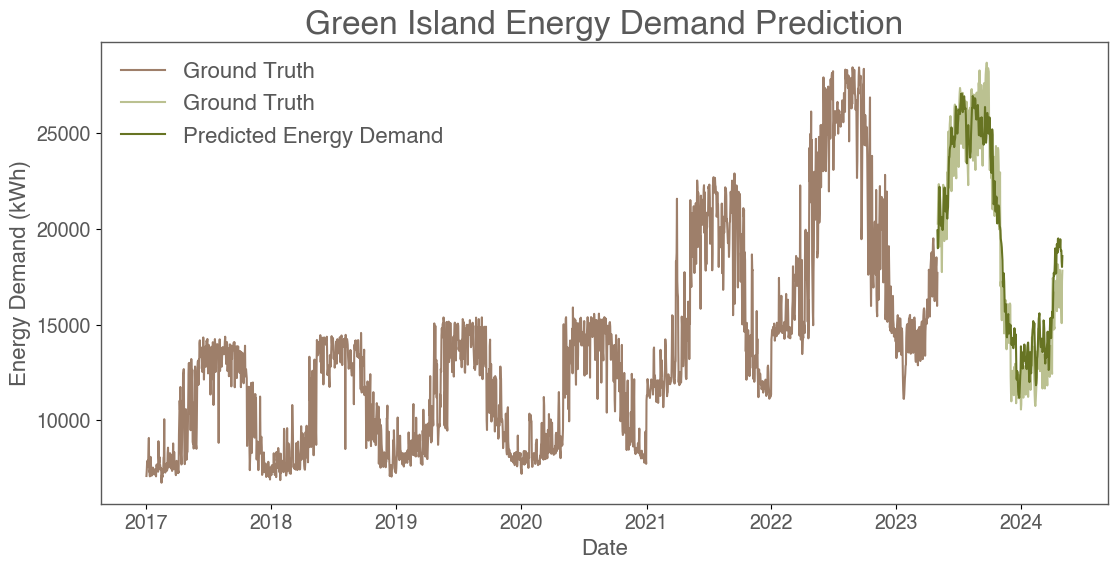

In [8]:
from matplotlib.font_manager import FontProperties

font_properties = FontProperties(family="Helvetica", size=16)

# Scaled error
# y_test_unscaled = y_test
# y_train_unscaled = y_train

# Calculate error for test set
test_mae = mean_absolute_error(y_test_unscaled, predicted_energy_usage)
test_mse = mean_squared_error(y_test_unscaled, predicted_energy_usage)
test_rmse = np.sqrt(test_mse)
test_r2 = r2_score(y_test_unscaled, predicted_energy_usage)

# Calculate error for training set
train_mae = mean_absolute_error(y_train_unscaled, train_predictions)
train_mse = mean_squared_error(y_train_unscaled, train_predictions)
train_rmse = np.sqrt(train_mse)
train_r2 = r2_score(y_train_unscaled, train_predictions)

print(f"Test Set Metrics:\nMAE: {test_mae}\nMSE: {test_mse}\nRMSE: {test_rmse}\nR-squared: {test_r2}")
print(f"Training Set Metrics:\nMAE: {train_mae}\nMSE: {train_mse}\nRMSE: {train_rmse}\nR-squared: {train_r2}")

# Plot results
plt.figure(figsize=(13, 6))
plt.plot(df.loc[:'2023-5-1', 'EnergyDemand'], label='Ground Truth', color='#9e7f6a')
plt.plot(df.loc['2023-5-2':, 'EnergyDemand'], label='Ground Truth', color='#bbc191')
plt.plot(test_data['PredictedEnergyDemand'], label='Predicted Energy Demand', color='#677423')
plt.legend(prop=font_properties, labelcolor='#595959', frameon=False)
plt.title('Green Island Energy Demand Prediction', fontsize=24, fontname="Helvetica", color='#595959')
plt.xlabel('Date', fontsize=16, fontname="Helvetica", color='#595959')
plt.xticks(color='#595959', fontsize=14, fontname="Helvetica")
plt.yticks(color='#595959', fontsize=14, fontname="Helvetica")
plt.ylabel('Energy Demand (kWh)', fontsize=16, fontname="Helvetica", color='#595959')
ax = plt.gca() 
ax.spines['top'].set_color('#595959')
ax.spines['bottom'].set_color('#595959')
ax.spines['left'].set_color('#595959')
ax.spines['right'].set_color('#595959')
ax.spines['top'].set_linewidth(1)
ax.spines['bottom'].set_linewidth(1)
ax.spines['left'].set_linewidth(1)
ax.spines['right'].set_linewidth(1)
plt.show()